## Metric: Feature tracking over a known, synthetic pixel offset, then calculate the difference between results and the ground truth

This method only uses **one source image** from the planned feature tracking pair. A arbitrary, synthetic pixel offset is applied to that image. The original image and the processed image form a pair, and we perform feature tracking using this pair. we calculate the difference between the offsets found by the FT algorithm and the ground truth (which is the arbitrary pixel offset). Similar to the post-correction off-ice errors, this difference can be used as a metric for determining the ideal FT parameters for the planned feature tracking pair.

Unlike the post-correction off-ice errors, this method requires no additional information and can be applied to any kind of source images. We create an offset field and applies it to a source image, creating the second, synthetic image to be used in the feature tracking algorithm. Then we run FT using this pair and compare the results with the ground truch (i.e. the original offset field).

### Requirements and Limits

- There are several steps needed to bo done before running FT. Users have to determine a few parameters for creating the synthetic offset field and create the second image. 
- Since it does not use the actual results from the planned feature tracking pair, this metric may fail to find the best parameter set for the actual pair when surface conditions change during the pair period (e.g. from snow melt).

### Procedure

1. Prepare the source image as a Geotiff file. 

2. Determine the parameters for the synthetic offset field and use `gftt.create_synthetic_offset` and `gftt.apply_synthetic_offset` to create pixel-shifted image. See this notebook for details.

3. Perform feature tracking algorithm and collect the resulting velocity field ($V_x$ and $V_y$) as geotiff files.

4. Use `gftt.syn_shift_errors` to calculate the deviation from the ground truth (the synthetic shift field). See this notebook for details.

### Analysis

#### 1. Information and map area

- Test area: Kaskawulsh
- Test package: CARST and Vmap
- Test source image: 20180304 (Landsat 8)

In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [2]:
import gftt
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# source file
image_geotiff = '../../data/LS8/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF'

In [4]:
src = rasterio.open(image_geotiff)

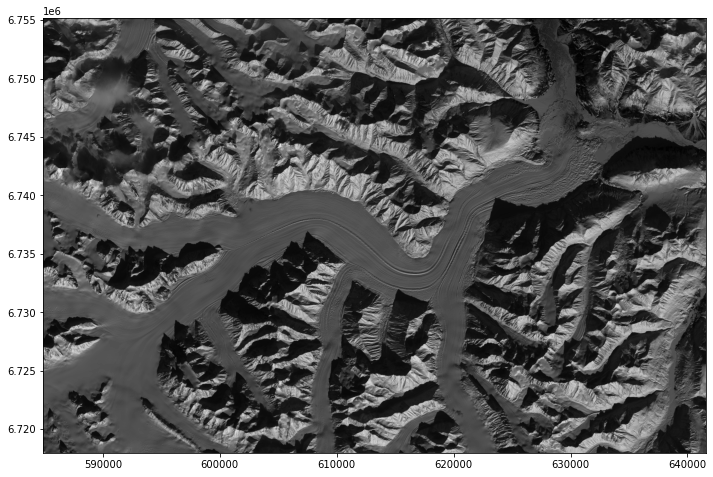

In [5]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8))
show(src, cmap='gray', ax=ax0);

#### 2. Create pixel-shifted image

We use the defaul parameters here:

- block size = 500 pixels
- spline order = 1 (linear interpolation)

In [6]:
shift_arx, shift_ary = gftt.create_synthetic_offset(image_geotiff)
shift_arx

array([[0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       ...,
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8]])

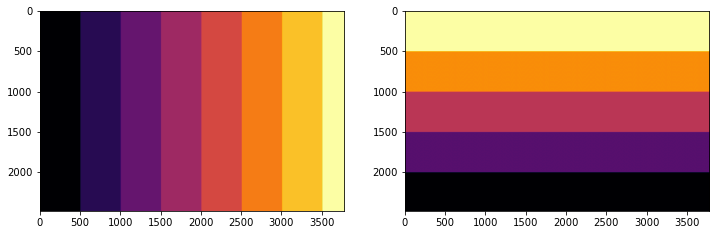

In [7]:
fig, ax1 = plt.subplots(1, 2, figsize=(12, 4))
ax1[0].imshow(shift_arx, cmap='inferno', vmin = 0.1, vmax = 0.8)
ax1[1].imshow(shift_ary, cmap='inferno', vmin = -0.5, vmax = -0.1);

In [8]:
shifted_image = gftt.apply_synthetic_offset(image_geotiff, shift_arx, shift_ary)

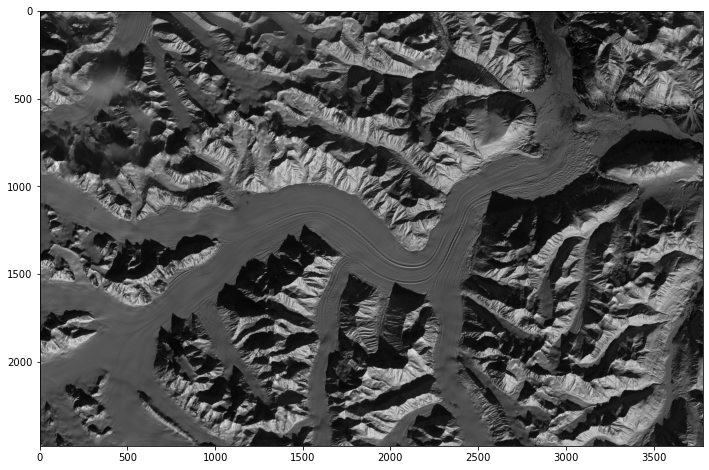

In [9]:
fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
ax2.imshow(shifted_image, cmap='gray');

Note that this should look really like the source image as the amount of offset is all within 1 pixel. We can save this image as a geotiff and perform feature tracking using whatever package to be tested.


In [10]:
kwds = src.profile
with rasterio.open('shifted_LS8_20180304.tif', 'w', **kwds) as dst:
    dst.write(shifted_image, 1)

In [32]:
kwds2 = src.profile
kwds2['dtype'] = 'float32'
with rasterio.open('shifted_array_x.tif', 'w', **kwds2) as dst:
    dst.write(shift_arx, 1)
with rasterio.open('shifted_array_y.tif', 'w', **kwds2) as dst:
    dst.write(shift_ary, 1)

#### 3. Run feature tracking using selected algorithm and parameter set

The pair to be used:
- `data/LS8/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF`
- `./shifted_LS8_20180304.tif`

CARST results are stored in `data/synthetic_offset_results_carst`.

#### 4. calculate the feature tracking deviation from the ground truth

In [33]:
# example: Kernel size = 8, skip = 8
result_x_geotiff = '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif'
result_y_geotiff = '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vy.tif'

src_x = rasterio.open(result_x_geotiff)
src_y = rasterio.open(result_y_geotiff)
# the original unit is in meters, and the pixel spacing is 15 meters
# to convert meters to pixel shift, we have to divide the results by 15
result_x_in_px = -src_x.read(1) / 15     # for unknown reason, CARST results seem to be sign-reversed
result_y_in_px = src_y.read(1) / 15  

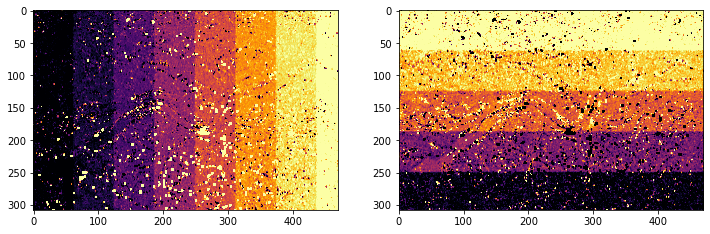

In [49]:
fig, ax3 = plt.subplots(1, 2, figsize=(12, 4))
ax3[0].imshow(result_x_in_px, vmin = 0.1, vmax = 0.8, cmap='inferno')
ax3[1].imshow(result_y_in_px, vmin = -0.5, vmax = -0.1, cmap='inferno')

In [35]:
%%bash
raster1='shifted_array_x.tif'
raster2="../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif"
raster3='shifted_array_y.tif'
raster4="../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vy.tif"
python /home/jovyan/.local/lib/python3.9/site-packages/pygeotools/warptool.py -tr $raster2 -te $raster2 -t_srs $raster2 $raster1
python /home/jovyan/.local/lib/python3.9/site-packages/pygeotools/warptool.py -tr $raster4 -te $raster4 -t_srs $raster4 $raster3

0...10...20...30...40...50...60...70...80...90...
Input parameters
Resolution: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif
Extent: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif
Projection: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif
Resampling alg: cubic


Warping all inputs to the following:
Resolution: 120.0
Extent: [584992.5, 6718102.5, 641392.5, 6755062.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 1: shifted_array_x.tif
nl: 308 ns: 470 res: 120.000
100 - done.
0...10...20...30...40...50...60...70...80...90...
Input parameters
Resolution: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vy.tif
Extent: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/201

In [36]:
with rasterio.open('shifted_array_x_warp.tif') as src_x2:
    shift_arx_s = src_x2.read(1)
with rasterio.open('shifted_array_y_warp.tif') as src_y2:
    shift_ary_s = src_y2.read(1)

In [39]:
diff_x = result_x_in_px - shift_arx_s
diff_y = result_y_in_px - shift_ary_s

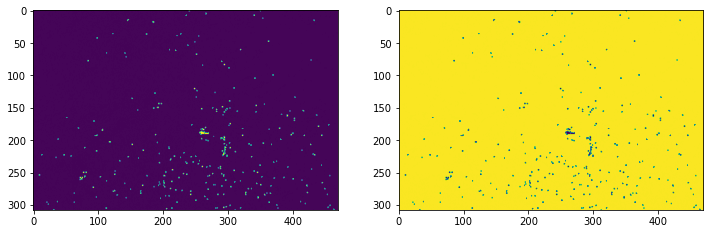

In [40]:
fig, ax4 = plt.subplots(1, 2, figsize=(12, 4))
ax4[0].imshow(diff_x) # , vmin = 0.1, vmax = 0.8, cmap='inferno')
ax4[1].imshow(diff_y) #, vmin = -0.5, vmax = -0.1, cmap='inferno')

(0.0, 1.0)

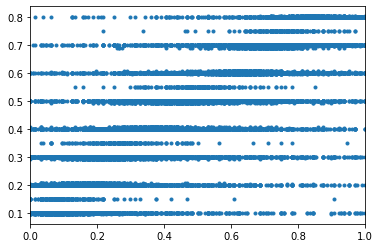

In [56]:
plt.plot(result_x_in_px.flatten(), shift_arx_s.flatten(), '.')
plt.xlim(0, 1)

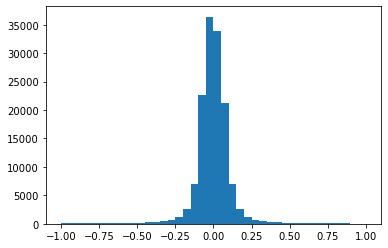

In [61]:
plt.hist(diff_x.flatten(), bins=np.linspace(-1, 1, 41));

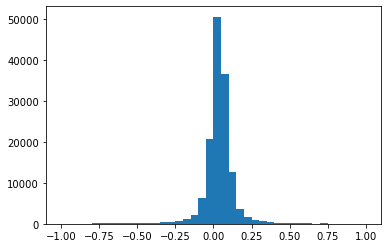

In [62]:
plt.hist(diff_y.flatten(), bins=np.linspace(-1, 1, 41));

In [48]:
shift_ary_s

array([[-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
       ...,
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5]], dtype=float32)

In [47]:
result_y_in_px

array([[-0.0625   ,  0.       , -0.03125  , ..., -0.09375  , -0.0625   ,
        -0.1875   ],
       [-0.0625   ,  0.       , -0.03125  , ..., -0.09375  , -0.0625   ,
        -0.0625   ],
       [-0.0625   , -0.0625   , -0.03125  , ..., -0.09375  , -0.09375  ,
         0.       ],
       ...,
       [-0.46875  , -0.4140625, -0.5546875, ..., -0.5234375, -0.4921875,
        -0.7734375],
       [-0.46875  , -0.4609375, -0.4453125, ..., -0.5078125, -0.421875 ,
        -0.515625 ],
       [-0.46875  , -0.4921875, -0.3828125, ..., -0.6171875, -0.4765625,
        -0.4453125]], dtype=float32)

In [51]:
result_x_in_px.flatten()

array([-0.       , -0.03125  ,  0.0625   , ...,  0.8359375,  0.8359375,
        0.7578125], dtype=float32)